<a href="https://colab.research.google.com/github/Abhishek734/Deep-learning-practice/blob/master/dogs_vs_cats_classification_on_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
from google.colab import files
files.upload()

# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 67 Sep 13 15:36 kaggle.json


In [2]:
# Copy the stackoverflow data set locally.
# accept the terms and conditions 
!kaggle competitions download -c dogs-vs-cats

from zipfile import ZipFile

filename='train.zip'
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('done!')

filename='test1.zip'
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('done!')

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 27.3MB/s]
 99% 268M/271M [00:04<00:00, 74.7MB/s]
100% 271M/271M [00:04<00:00, 62.8MB/s]
100% 543M/543M [00:08<00:00, 76.4MB/s]
100% 543M/543M [00:08<00:00, 64.0MB/s]
done!
done!


In [3]:
from sklearn .model_selection import train_test_split
import matplotlib.pyplot as plt

import os
print(os.listdir())

['.config', 'sampleSubmission.csv', 'train.zip', 'test1.zip', 'test1', 'train', 'kaggle.json', 'sample_data']


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

import os
# print(os.listdir("train/"))


Using TensorFlow backend.


# Prepare Traning Data

In [5]:
filenames = os.listdir("train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,dog.3157.jpg,1
1,dog.7325.jpg,1
2,dog.11718.jpg,1
3,dog.8292.jpg,1
4,dog.4832.jpg,1


### See Total In count

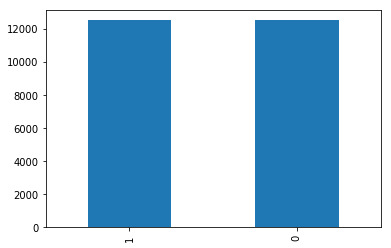

In [6]:
df['category'].value_counts().plot.bar()

# See sample image

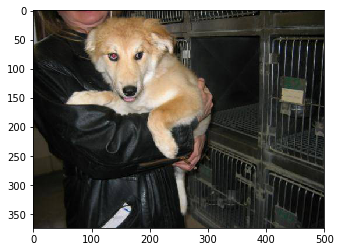

In [7]:
sample = random.choice(filenames)
image = load_img("train/"+sample)
plt.imshow(image)

# Build Model

In [8]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()





58892288/58889256 [==============================] - 5s 0us/step


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 1

# Prepare Test and Train Data

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
train_df["category"] = train_df["category"].replace({0: 'cat', 1: 'dog'}) 

validate_df = validate_df.reset_index()
validate_df["category"] = validate_df["category"].replace({0: 'cat', 1: 'dog'}) 


# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

# Traning Generator

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 22500 validated image filenames belonging to 2 classes.


# Validation Generator

In [11]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2500 validated image filenames belonging to 2 classes.


# See sample generated images

In [0]:
# example_df = train_df.sample(n=1).reset_index(drop=True)
# example_generator = train_datagen.flow_from_dataframe(
#     example_df, 
#     "train/", 
#     x_col='filename',
#     y_col='category',
#     class_mode='binary'
# )
# plt.figure(figsize=(12, 12))
# for i in range(0, 9):
#     plt.subplot(3, 3, i+1)
#     for X_batch, Y_batch in example_generator:
#         image = X_batch[0]
#         plt.imshow(image)
#         break
# plt.tight_layout()
# plt.show()

# Fit Model

In [13]:
# fine-tune the model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/5
1406/1406 [==============================] - 408s 291ms/step - loss: 0.2955 - acc: 0.8643 - val_loss: 0.1404 - val_acc: 0.9407
Epoch 2/5
1406/1406 [==============================] - 400s 285ms/step - loss: 0.1520 - acc: 0.9383 - val_loss: 0.1144 - val_acc: 0.9525
Epoch 3/5
1406/1406 [==============================] - 399s 284ms/step - loss: 0.1274 - acc: 0.9489 - val_loss: 0.1049 - val_acc: 0.9597
Epoch 4/5
1406/1406 [==============================] - 399s 284ms/step - loss: 0.1122 - acc: 0.9565 - val_loss: 0.0977 - val_acc: 0.9650
Epoch 5/5
1406/1406 [==============================] - 401s 285ms/step - loss: 0.1029 - acc: 0.9597 - val_loss: 0.0911 - val_acc: 0.9626


In [14]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.962740  ;  loss = 0.091555 


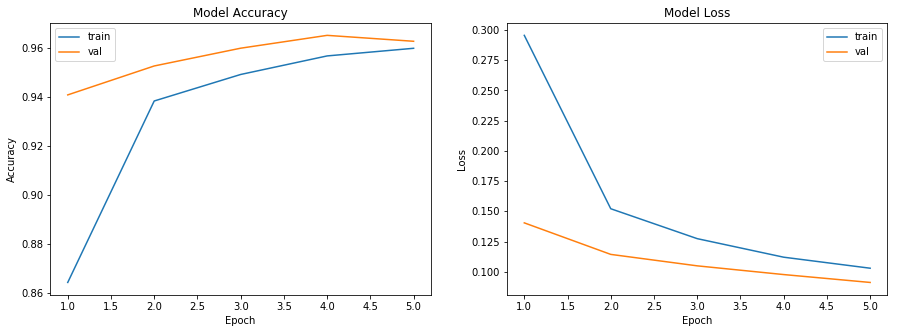

In [15]:
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [0]:
validate_df["category"] = validate_df["category"].replace({ 'cat':0,  'dog':1}) 


Y_val = validate_df['category']
y_pred =  model.predict_generator(validation_generator)

In [0]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)

In [18]:
y_final.size

2500

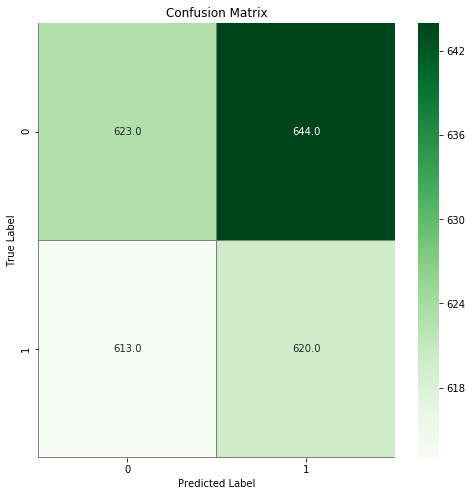

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [20]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, y_final, target_names=['0','1'])

print(report)

              precision    recall  f1-score   support

           0       0.50      0.49      0.50      1267
           1       0.49      0.50      0.50      1233

    accuracy                           0.50      2500
   macro avg       0.50      0.50      0.50      2500
weighted avg       0.50      0.50      0.50      2500



# Prepare Testing Data

In [0]:
test_filenames = os.listdir("test1/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [22]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 12500 validated image filenames.


# Predict

In [0]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

# See predicted result

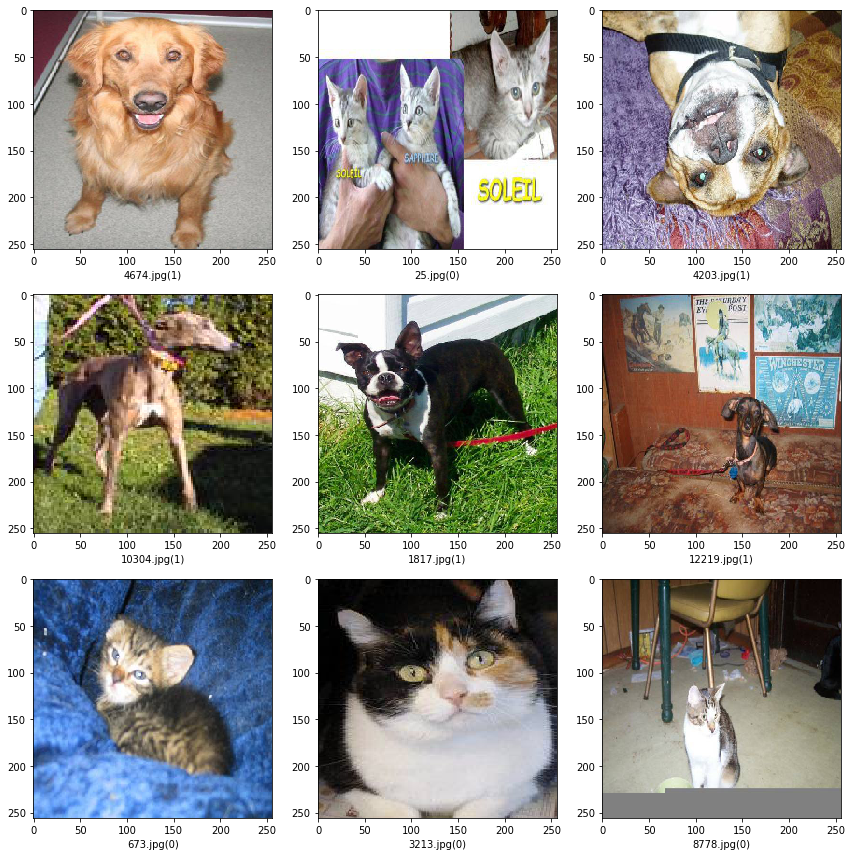

In [24]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

# Submission

Text(0.5, 1.0, '(Test data)')

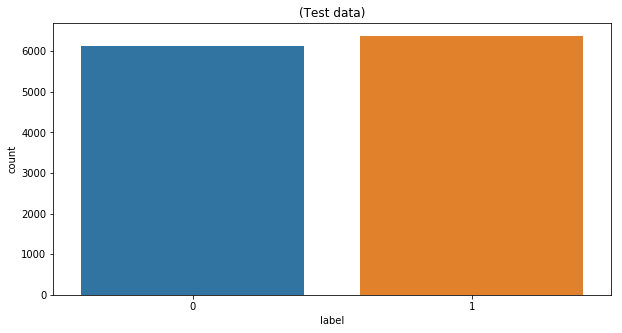

In [25]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_13010030.csv', index=False)

plt.figure(figsize=(10,5))
sns.countplot(submission_df['label'])
plt.title("(Test data)")